In [1]:
import numpy as np
import torch
import os
import net
import utils
from PIL import Image
from tqdm import tqdm
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torchvision.utils import save_image, make_grid
from time import time
import pickle
import random
from pathlib import Path

torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

In [2]:
BATCH_SIZE = 32
DS_FOLDER = "/home/ML_courses/03683533_2021/dataset"
LR = 1e-5
DEVICE_ID = 0
VAL_RANGE = 1000
TRAIN_RANGE = None
NUM_WORKERS = 16
NUM_EPOCHS = 40
SHUFFLE = False
RUN_NAME = f'Alex-LR-{LR}'

# Network and optimizer

In [3]:
model = net.AutoEncoder()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
device = f'cuda:{DEVICE_ID}' if torch.cuda.is_available() else 'cpu'
print(device)
model.to(device)

cuda:0


/home/ML_courses/03683533_2021/maya_gal_ofek/condaEnv/lib/python3.8/site-packages/torch/cuda/__init__.py:120: UserWarning: 
    Found GPU%d %s which is of cuda capability %d.%d.
    PyTorch no longer supports this GPU because it is too old.
    The minimum cuda capability supported by this library is %d.%d.
    
  warnings.warn(old_gpu_warn.format(d, name, major, minor, min_arch // 10, min_arch % 10))


AutoEncoder(
  (activation): LeakyReLU(negative_slope=0.01)
  (last_activation): Sigmoid()
  (enc1): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4), padding=(4, 4))
  (enc1_bn): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (enc2): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (enc2_bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (enc3): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1))
  (enc3_bn): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (enc4): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1))
  (enc4_bn): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (enc5): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (enc5_bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

# Data Loader & Dataset

In [4]:
transform = transforms.Compose([transforms.Resize(256),
                                transforms.ToTensor(),
                                ])

class UniDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform
        
    def __getitem__(self, index):
        image_path = self.image_paths[index]
        x = Image.open(image_path)
        if self.transform is not None:
            x = self.transform(x)
        return x
    
    def __len__(self):
        return len(self.image_paths)

In [5]:
val_files = [os.path.join(DS_FOLDER,i) for i in sorted(os.listdir(DS_FOLDER))[:VAL_RANGE]]
if TRAIN_RANGE != None:
    train_files = [os.path.join(DS_FOLDER,i) for i in 
                   sorted(os.listdir(DS_FOLDER))[VAL_RANGE+1:TRAIN_RANGE+1+VAL_RANGE]]
else:
    train_files = [os.path.join(DS_FOLDER,i) for i in sorted(os.listdir(DS_FOLDER))[VAL_RANGE+1:]]

In [6]:
val_ds = UniDataset(val_files, transform=transform)
train_ds = UniDataset(train_files, transform=transform)

In [7]:
val_dl = DataLoader(val_ds, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, pin_memory=True, shuffle=SHUFFLE)

/home/ML_courses/03683533_2021/maya_gal_ofek/condaEnv/lib/python3.8/site-packages/torch/utils/data/dataloader.py:478: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


# Train model

In [8]:
def save_imgs(true_imgs, val_imgs, dirname, epoch):
    path = os.path.join('results', RUN_NAME, epoch)
    os.makedirs(path, exist_ok=True)
    save_image(val_imgs, os.path.join(path, 'val_pred.png'))
    save_image(true_imgs, os.path.join(path, 'val_true.png'))

In [9]:
def calc_val_loss(val_dl, epoch, dirname):
    with torch.no_grad():
        val_loss = 0.0
        for images in val_dl:
            images = images.float().to(device)
            outputs = model(images)
            images.require_grad = False
            loss = criterion(outputs, images)
            val_loss += loss.item()
    images = images.cpu()
    outputs = outputs.view(outputs.size(0), 3, 256, 256).cpu().data
    save_imgs(images, outputs, dirname, epoch)
    return val_loss/len(val_dl), make_grid(images), make_grid(outputs)

In [10]:
%%time

train_losses = {}
val_losses = {}
for epoch in range(1, NUM_EPOCHS+1):
    t = time()
    train_loss = 0.0
    for images in tqdm(train_dl):
        images = images.float()
        images = images.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, images)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    val_loss, val_true_grid, val_pred_grid = calc_val_loss(val_dl, str(epoch), RUN_NAME)
    train_loss = train_loss/len(train_dl)
    train_losses[epoch] = train_loss
    val_losses[epoch] = val_loss
    print('Epoch: {} \tTraining Loss: {:.6f} \tVal Loss: {:.6f}\t \
    in time {:2f}m'.format(epoch, train_loss, val_loss, (time()-t)/60))


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1219/1219 [02:09<00:00,  9.40it/s]


Epoch: 1 	Training Loss: 0.068609 	Val Loss: 0.062409	     in time 2.227786m


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1219/1219 [02:08<00:00,  9.46it/s]


Epoch: 2 	Training Loss: 0.056903 	Val Loss: 0.053198	     in time 2.222487m


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1219/1219 [02:07<00:00,  9.54it/s]


Epoch: 3 	Training Loss: 0.048842 	Val Loss: 0.045856	     in time 2.203851m


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1219/1219 [02:07<00:00,  9.58it/s]


Epoch: 4 	Training Loss: 0.041971 	Val Loss: 0.039334	     in time 2.196781m


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1219/1219 [02:07<00:00,  9.58it/s]


Epoch: 5 	Training Loss: 0.035934 	Val Loss: 0.033659	     in time 2.196298m


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1219/1219 [02:06<00:00,  9.60it/s]


Epoch: 6 	Training Loss: 0.030671 	Val Loss: 0.028701	     in time 2.191561m


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1219/1219 [02:06<00:00,  9.61it/s]


Epoch: 7 	Training Loss: 0.026108 	Val Loss: 0.024439	     in time 2.191563m


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1219/1219 [02:07<00:00,  9.59it/s]


Epoch: 8 	Training Loss: 0.022229 	Val Loss: 0.020850	     in time 2.196333m


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1219/1219 [02:07<00:00,  9.60it/s]


Epoch: 9 	Training Loss: 0.019010 	Val Loss: 0.017908	     in time 2.195682m


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1219/1219 [02:07<00:00,  9.59it/s]


Epoch: 10 	Training Loss: 0.016394 	Val Loss: 0.015535	     in time 2.194737m


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1219/1219 [02:07<00:00,  9.59it/s]


Epoch: 11 	Training Loss: 0.014299 	Val Loss: 0.013642	     in time 2.196707m


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1219/1219 [02:07<00:00,  9.57it/s]


Epoch: 12 	Training Loss: 0.012633 	Val Loss: 0.012141	     in time 2.202850m


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1219/1219 [02:07<00:00,  9.59it/s]


Epoch: 13 	Training Loss: 0.011304 	Val Loss: 0.010944	     in time 2.198594m


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1219/1219 [02:07<00:00,  9.58it/s]


Epoch: 14 	Training Loss: 0.010236 	Val Loss: 0.009980	     in time 2.198149m


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1219/1219 [02:07<00:00,  9.59it/s]


Epoch: 15 	Training Loss: 0.009366 	Val Loss: 0.009195	     in time 2.195936m


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1219/1219 [02:06<00:00,  9.61it/s]


Epoch: 16 	Training Loss: 0.008652 	Val Loss: 0.008543	     in time 2.192464m


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1219/1219 [02:07<00:00,  9.60it/s]


Epoch: 17 	Training Loss: 0.008056 	Val Loss: 0.007992	     in time 2.195422m


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1219/1219 [02:07<00:00,  9.58it/s]


Epoch: 18 	Training Loss: 0.007549 	Val Loss: 0.007508	     in time 2.196027m


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1219/1219 [02:07<00:00,  9.60it/s]


Epoch: 19 	Training Loss: 0.007102 	Val Loss: 0.007081	     in time 2.195506m


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1219/1219 [02:06<00:00,  9.62it/s]


Epoch: 20 	Training Loss: 0.006704 	Val Loss: 0.006698	     in time 2.190131m


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1219/1219 [02:07<00:00,  9.58it/s]


Epoch: 21 	Training Loss: 0.006351 	Val Loss: 0.006358	     in time 2.198157m


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1219/1219 [02:07<00:00,  9.58it/s]


Epoch: 22 	Training Loss: 0.006041 	Val Loss: 0.006063	     in time 2.199205m


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1219/1219 [02:07<00:00,  9.56it/s]


Epoch: 23 	Training Loss: 0.005774 	Val Loss: 0.005810	     in time 2.209182m


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1219/1219 [02:08<00:00,  9.51it/s]


Epoch: 24 	Training Loss: 0.005548 	Val Loss: 0.005602	     in time 2.212718m


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1219/1219 [02:07<00:00,  9.58it/s]


Epoch: 25 	Training Loss: 0.005358 	Val Loss: 0.005426	     in time 2.198860m


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1219/1219 [02:07<00:00,  9.59it/s]


Epoch: 26 	Training Loss: 0.005199 	Val Loss: 0.005281	     in time 2.198623m


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1219/1219 [02:06<00:00,  9.61it/s]


Epoch: 27 	Training Loss: 0.005064 	Val Loss: 0.005161	     in time 2.193427m


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1219/1219 [02:08<00:00,  9.49it/s]


Epoch: 28 	Training Loss: 0.004948 	Val Loss: 0.005057	     in time 2.216244m


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1219/1219 [02:07<00:00,  9.60it/s]


Epoch: 29 	Training Loss: 0.004847 	Val Loss: 0.004970	     in time 2.194769m


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1219/1219 [02:07<00:00,  9.58it/s]


Epoch: 30 	Training Loss: 0.004757 	Val Loss: 0.004894	     in time 2.197169m


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1219/1219 [02:06<00:00,  9.61it/s]


Epoch: 31 	Training Loss: 0.004676 	Val Loss: 0.004829	     in time 2.191892m


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1219/1219 [02:07<00:00,  9.57it/s]


Epoch: 32 	Training Loss: 0.004605 	Val Loss: 0.004773	     in time 2.199080m


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1219/1219 [02:07<00:00,  9.58it/s]


Epoch: 33 	Training Loss: 0.004547 	Val Loss: 0.004739	     in time 2.197369m


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1219/1219 [02:07<00:00,  9.59it/s]


Epoch: 34 	Training Loss: 0.004488 	Val Loss: 0.004610	     in time 2.194455m


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1219/1219 [02:07<00:00,  9.60it/s]


Epoch: 35 	Training Loss: 0.004418 	Val Loss: 0.004525	     in time 2.193624m


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1219/1219 [02:07<00:00,  9.59it/s]


Epoch: 36 	Training Loss: 0.004333 	Val Loss: 0.004447	     in time 2.198213m


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1219/1219 [02:07<00:00,  9.56it/s]


Epoch: 37 	Training Loss: 0.004245 	Val Loss: 0.004365	     in time 2.202383m


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1219/1219 [02:07<00:00,  9.59it/s]


Epoch: 38 	Training Loss: 0.004159 	Val Loss: 0.004283	     in time 2.193882m


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1219/1219 [02:06<00:00,  9.60it/s]


Epoch: 39 	Training Loss: 0.004078 	Val Loss: 0.004206	     in time 2.190330m


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1219/1219 [02:07<00:00,  9.59it/s]


Epoch: 40 	Training Loss: 0.004009 	Val Loss: 0.004150	     in time 2.202821m
CPU times: user 1h 15min 3s, sys: 24min 3s, total: 1h 39min 6s
Wall time: 1h 27min 57s


In [11]:
%%time

train_losses = {}
val_losses = {}
for epoch in range(21, 31):
    t = time()
    train_loss = 0.0
    for images in tqdm(train_dl):
        images = images.float()
        images = images.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, images)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    val_loss, val_true_grid, val_pred_grid = calc_val_loss(val_dl, str(epoch), RUN_NAME)
    train_loss = train_loss/len(train_dl)
    train_losses[epoch] = train_loss
    val_losses[epoch] = val_loss
    print('Epoch: {} \tTraining Loss: {:.6f} \tVal Loss: {:.6f}\t \
    in time {:2f}m'.format(epoch, train_loss, val_loss, (time()-t)/60))


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1219/1219 [02:06<00:00,  9.61it/s]


Epoch: 21 	Training Loss: 0.003951 	Val Loss: 0.004088	     in time 2.194712m


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1219/1219 [02:06<00:00,  9.60it/s]


Epoch: 22 	Training Loss: 0.003905 	Val Loss: 0.004043	     in time 2.197556m


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1219/1219 [02:06<00:00,  9.62it/s]


Epoch: 23 	Training Loss: 0.003866 	Val Loss: 0.004028	     in time 2.192748m


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1219/1219 [02:07<00:00,  9.59it/s]


Epoch: 24 	Training Loss: 0.003826 	Val Loss: 0.004022	     in time 2.199792m


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1219/1219 [02:07<00:00,  9.57it/s]


Epoch: 25 	Training Loss: 0.003791 	Val Loss: 0.004000	     in time 2.203201m


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1219/1219 [02:07<00:00,  9.55it/s]


Epoch: 26 	Training Loss: 0.003760 	Val Loss: 0.003964	     in time 2.204713m


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1219/1219 [02:06<00:00,  9.60it/s]


Epoch: 27 	Training Loss: 0.003736 	Val Loss: 0.003924	     in time 2.191033m


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1219/1219 [02:07<00:00,  9.58it/s]


Epoch: 28 	Training Loss: 0.003717 	Val Loss: 0.003870	     in time 2.196949m


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1219/1219 [02:07<00:00,  9.56it/s]


Epoch: 29 	Training Loss: 0.003695 	Val Loss: 0.003843	     in time 2.202711m


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1219/1219 [02:07<00:00,  9.55it/s]


Epoch: 30 	Training Loss: 0.003663 	Val Loss: 0.003808	     in time 2.202204m
CPU times: user 18min 46s, sys: 6min 2s, total: 24min 49s
Wall time: 21min 59s


# Results

In [12]:
def show(img, ax = None):
    npimg = img.numpy()
    ax.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    
path = Path("results") / RUN_NAME

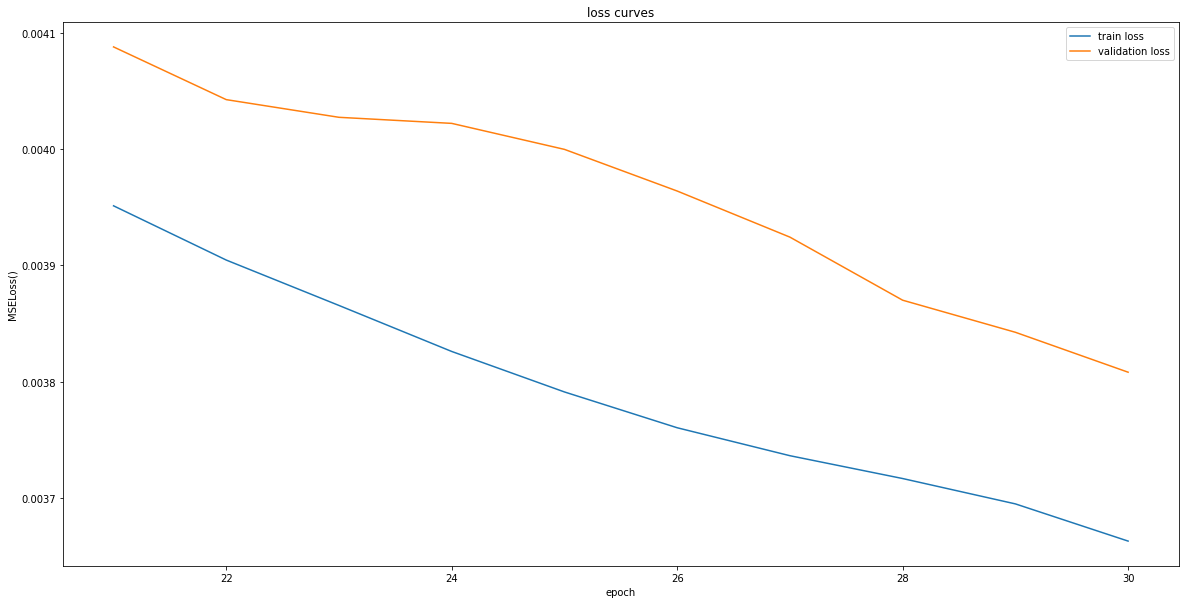

In [13]:
fig, ax = plt.subplots(figsize=(20, 10))
plt.plot(train_losses.keys(), train_losses.values(), label="train loss")
plt.plot(val_losses.keys(), val_losses.values(), label="validation loss")
plt.title("loss curves")
plt.legend()
plt.xlabel("epoch")
plt.ylabel(str(criterion))
plt.savefig(path / "loss_curves.png")

In [14]:
with open(path / "loss_values.txt", "w") as f:
    for i in train_losses.keys():
        f.write(f"epoch {i}: train loss is {train_losses[i]:.6f}, validation loss is {val_losses[i]:.6f}\n")

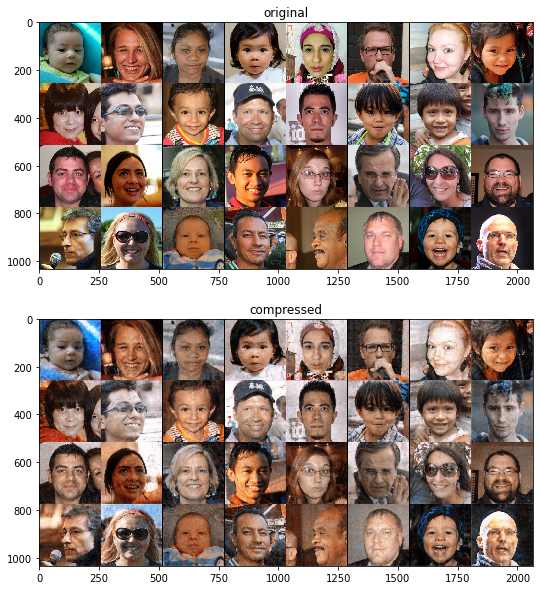

In [15]:
images = list(val_dl)[0]
outputs = model(images.to(device)).cpu()

fig, axes = plt.subplots(2, figsize=(20, 10))
show(make_grid(images), axes[0])
axes[0].set_title("original")
show(make_grid(outputs), axes[1])
axes[1].set_title("compressed")
plt.savefig( path / 'validation_compare.png')